<a href="https://colab.research.google.com/github/prbocca/meli_ds/blob/main/meli_ds_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Science challenge 

El desafío consta de 5 ejercicios independientes que van desde análisis exploratorio, machine learning o el diseño de una solución de data science.

¿Qué evaluamos?
El desafío busca evaluar distintos aspectos como:
* Capacidad analitica y exploración de datos
* Visualización de resultados
* Conocimientos de técnicas de generación de features y modelado
* Análisis de performance
* Buenas prácticas de desarrollo
* Diseño e implementación de Machine learning en producción

Algunas reglas y recomendaciones:
1. Si bien son 5 ejercicios dejamos a elección del postulante cuales resolver salvo
por el primero que es obligatorio como parte del desafío.
2. Un número recomendado a resolver son 3 de los 5 desafíos, pero sentite libre
de resolver la cantidad deseada.
3. La mayoría de los ejercicios se piden resolver en Jupyter notebooks y te
recomendamos subirlas a un repositorio de GitHub público para compartir los
resultados.
4. No dejes de hacernos preguntas sobre cualquier duda con los enunciados

El desafío se analiza de acuerdo al seniority del postulante y teniendo en cuenta también las necesidades particulares de la posición.

# 4. Series de tiempo

## Descripción

Pronosticar las ventas de un producto o de una categoría es un desafío recurrente para cualquier ecommerce.
En este caso, el desafío va a ser pronosticar la cantidad de unidades diarias que van a vender 3 categorías distintas de MELI.
El dataset `series.csv` tiene las ventas en unidades diarias de 3 categorías que poseen un id único y su fecha de venta.

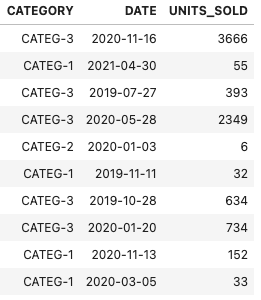



## Entregable

El objetivo de este desafío es construir un modelo de forecast que permita estimar las ventas de 3 semanas a nivel diario utilizando la historia de ventas de la categoría. Es decir, predecir las ventas de los siguientes 21 días. Las métricas y la medición de la
performance del forecast son un punto clave de este desafío.

TIP: Dividir el dataset en entrenamiento, testing y validación correctamente es muy importante en problemas de forecasting!



## Asumimos lo siguiente:

* sin asumsiones

*  usaremos código de terceros, en especial de: https://www.tensorflow.org/tutorials/structured_data/time_series

In [278]:
# version
from datetime import datetime

print(datetime.now())

2022-10-27 22:01:15.261612


In [279]:
# installs

'''
! pip install lightgbm
! pip install optuna
! pip install dask

#!pip install plotly==4.2.1
!pip install plotly
!pip install plotly_express
'''

'\n! pip install lightgbm\n! pip install optuna\n! pip install dask\n\n#!pip install plotly==4.2.1\n!pip install plotly\n!pip install plotly_express\n'

In [280]:
# liberias

from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import random
import os
import shutil
import gc
import bz2
import pickle
import _pickle as cPickle
import numpy as np
import pandas as pd

#import plotly_express as px
#import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import json
import string
import re

import warnings
warnings.filterwarnings('ignore')

import time 
from datetime import datetime, timedelta

#import lightgbm as lgb
#import dask_xgboost as xgb
#import dask.dataframe as dd
import sklearn as sk
#from sklearn import preprocessing, metrics
#from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit

import IPython
from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual
import ipywidgets as widgets
from IPython.display import display
from tqdm import tnrange, tqdm_notebook

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13) #Setting seed to ensure reproducibility.

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [281]:
# funciones auxiliares

def plot_line(df, title=None, xlabel=None, ylabel=None,
              h=None, v=None, xlim=(None, None), ylim=(0, None),
              math_scale=False, y_logscale=False, y_integer=False,
              show_legend=True, bbox_to_anchor=(1.02, 0),  bbox_loc="lower left", subplots=False, figsize = (20, 5)):
    """
    Show chlonological change of the data.
    """
    ax = df.plot(subplots=subplots, figsize = figsize)
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
    if y_logscale:
        ax.set_yscale("log")
        if ylim[0] == 0:
            ylim = (None, None)
    if y_integer:
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        ax.yaxis.set_major_formatter(fmt)
    if not subplots:
      ax.set_title(title)
      ax.set_xlabel(xlabel)
      ax.set_ylabel(ylabel)
      ax.set_xlim(*xlim)
      ax.set_ylim(*ylim)
      if show_legend:
          ax.legend(bbox_to_anchor=bbox_to_anchor, loc=bbox_loc, borderaxespad=0)
      else:
          ax.legend().set_visible(False)
      #if h is not None:
      #    ax.axhline(y=h, color="black", linestyle="--")
      if h is not None:
          if not (isinstance(h, list) or isinstance(h, np.ndarray)):
              h = [h]
          for value in h:
              ax.axhline(y=value, color="grey", linestyle="--")
      if v is not None:
          if not isinstance(v, list):
              v = [v]
          for value in v:
              ax.axvline(x=value, color="grey", linestyle="--")
    else:
      ax[0].set_title(title)
      ax[len(ax)//2].set_ylabel(ylabel)
      for myax in ax:
        myax.set_xlabel(xlabel)
        myax.set_xlim(*xlim)
        myax.set_ylim(*ylim)
        if show_legend:
            myax.legend(bbox_to_anchor=bbox_to_anchor, loc=bbox_loc, borderaxespad=0)
        else:
            myax.legend().set_visible(False)
        #if h is not None:
        #    ax.axhline(y=h, color="black", linestyle="--")
        if isinstance(h, np.ndarray):
            for sp in range(len(h)):
                myax.axhline(y=h[sp], color="grey", linestyle="--")
        elif isinstance(h, float) or isinstance(h, int):
            myax.axhline(y=h, color="grey", linestyle="--")
        if v is not None:
            if not isinstance(v, list):
                v = [v]
            for value in v:
                myax.axvline(x=value, color="grey", linestyle="--")

    
    plt.figure(num=None, figsize=(128, 24), dpi=80, facecolor='w', edgecolor='k')
    plt.tight_layout()
    plt.show()
    return ax


#normalize
def normalize(dataset, data_mean, data_std):
  dataset = np.nan_to_num(dataset) #substitute NaN by Zeros
  dataset = (dataset-data_mean)/data_std #Let's standardize the data.
  return dataset

def denormalize(dataset, data_mean, data_std):
  dataset = data_std*dataset + data_mean #Let's recover the data.
  return dataset

#comparision
def mape(A, B):
  return np.mean(np.abs((A - B) / A)) * 100

def rmse(A, B):
  return np.sqrt(np.square(np.subtract(A, B)).mean())

def mae(A, B):
  return np.abs(np.subtract(A, B)).mean()

def rrmse(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

def rae(true, pred):
    true_mean = np.mean(true)
    squared_error_num = np.sum(np.abs(true - pred))
    squared_error_den = np.sum(np.abs(true - true_mean))
    rae_loss = squared_error_num / squared_error_den
    return rae_loss

In [282]:
# configuración

data_filename = 'https://raw.githubusercontent.com/prbocca/meli_ds/main/data/series.csv'

# Load & preprocessing data

In [283]:
dataset_raw_df = pd.read_csv(data_filename, sep=",", engine='python')
dataset_raw_df['DATE'] = pd.to_datetime(dataset_raw_df["DATE"], format='%Y-%m-%d')
dataset_raw_df.sort_values(['DATE','CATEGORY'], ascending=True, inplace=True)

display(dataset_raw_df.info())
display(dataset_raw_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2686 entries, 1818 to 1039
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CATEGORY    2686 non-null   object        
 1   DATE        2686 non-null   datetime64[ns]
 2   UNITS_SOLD  2686 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 83.9+ KB


None

,CATEGORY,DATE,UNITS_SOLD
1818,CATEG-3,2018-09-24,0
2136,CATEG-3,2018-09-25,0
1803,CATEG-3,2018-09-27,0
669,CATEG-3,2018-09-28,2
2617,CATEG-3,2018-09-29,1
...,...,...,...
2538,CATEG-2,2021-11-11,20
2482,CATEG-3,2021-11-11,6294
1423,CATEG-1,2021-11-12,146
2372,CATEG-2,2021-11-12,12


In [284]:
# remove first few values
dataset_raw_df = dataset_raw_df[dataset_raw_df['DATE'].dt.year > 2018]

display(dataset_raw_df.info())
display(dataset_raw_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2650 entries, 506 to 1039
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CATEGORY    2650 non-null   object        
 1   DATE        2650 non-null   datetime64[ns]
 2   UNITS_SOLD  2650 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 82.8+ KB


None

,CATEGORY,DATE,UNITS_SOLD
506,CATEG-1,2019-06-11,27
2369,CATEG-2,2019-06-11,15
1375,CATEG-3,2019-06-11,642
1539,CATEG-1,2019-06-12,26
1503,CATEG-2,2019-06-12,13
...,...,...,...
2538,CATEG-2,2021-11-11,20
2482,CATEG-3,2021-11-11,6294
1423,CATEG-1,2021-11-12,146
2372,CATEG-2,2021-11-12,12


CATEGORY,CATEG-1,CATEG-2,CATEG-3
DATE,,,
2019-06-11,27,15,642
2019-06-12,26,13,679
2019-06-13,24,8,561
2019-06-14,18,9,520
2019-06-15,15,9,422
...,...,...,...
2021-11-08,63,21,2812
2021-11-09,65,13,2894
2021-11-10,189,18,7551


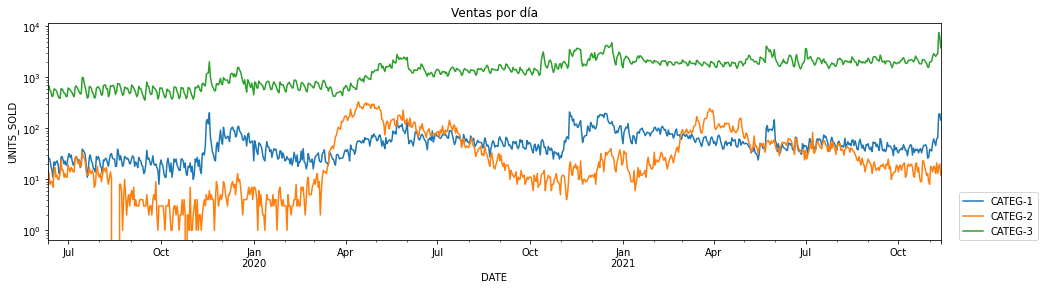

<Figure size 10240x1920 with 0 Axes>

,count,mean,std,min,25%,50%,75%,max
CATEGORY,,,,,,,,
CATEG-1,886.0,53.189616,31.891344,8.0,31.0,47.0,65.0,210.0
CATEG-2,886.0,44.392777,59.365071,0.0,9.0,19.0,51.0,332.0
CATEG-3,886.0,1513.197517,837.073072,357.0,708.0,1505.5,2022.0,7551.0


In [285]:
dataset_raw_pivot_df = dataset_raw_df.pivot(index='DATE', columns=['CATEGORY'], values='UNITS_SOLD').fillna(0).astype(int) #pivoteamos, eliminamos los MLU repetidos por dia, y completeamos con cero
display(dataset_raw_pivot_df)

plot_line(dataset_raw_pivot_df, 
          "Ventas por día", xlabel='DATE', ylabel="UNITS_SOLD",
          xlim=(None, None), ylim=(0, None),
          math_scale=False, y_logscale=True, y_integer=False,
          show_legend=True, bbox_to_anchor=(1.02, 0),  bbox_loc="lower left", subplots=False, figsize=(16,4))

# stats summary
display(dataset_raw_pivot_df.describe().transpose())

In [286]:
# completo si faltan dias: no faltan días

all_dates = pd.date_range(start=dataset_raw_pivot_df.index.min(), end=dataset_raw_pivot_df.index.max(), freq='D', name='DATE')
#display(all_dates) # parecen estar todas las fechas
dataset_raw_pivot2_df = dataset_raw_pivot_df.reindex(all_dates).fillna(0).astype(int) #agrego fechas faltantes y pongo ventas nulas
dataset_raw_pivot2_df.equals(dataset_raw_pivot_df)

True

# Processing

In [287]:
df = dataset_raw_pivot_df.reset_index().copy()

display(df.info())
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886 entries, 0 to 885
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   DATE     886 non-null    datetime64[ns]
 1   CATEG-1  886 non-null    int64         
 2   CATEG-2  886 non-null    int64         
 3   CATEG-3  886 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.8 KB


None

CATEGORY,DATE,CATEG-1,CATEG-2,CATEG-3
0,2019-06-11,27,15,642
1,2019-06-12,26,13,679
2,2019-06-13,24,8,561
3,2019-06-14,18,9,520
4,2019-06-15,15,9,422
...,...,...,...,...
881,2021-11-08,63,21,2812
882,2021-11-09,65,13,2894
883,2021-11-10,189,18,7551
884,2021-11-11,194,20,6294


## Feature engineering

Carecemos de toda información relacionada a la categoría, por lo que practicamente no podemos construir features. 
Nos limitaremos a los features temporales

In [288]:
target_columns = ['CATEG-1','CATEG-2','CATEG-3']

features_columns = [
    #'DATE', 
    'CATEG-1', 'CATEG-2', 'CATEG-3', 
    #'timestamp_s', 
    'year_sin', #'year_cos', 
    'weekday', #'year', 'month', 'week', 'day', 'weekday_name',
    'workday', 'busday',
    'shift_workday_t21','shift_busday_t21',
    #'rolling_sum_workday_t21', 'shift_rolling_sum_workday_t21'
]

NUM_TARGETS = len(target_columns)

In [289]:
df['timestamp_s'] = df['DATE'].map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day
df['year_sin'] = np.sin(df['timestamp_s'] * (2 * np.pi / year))
df['year_cos'] = np.cos(df['timestamp_s'] * (2 * np.pi / year))

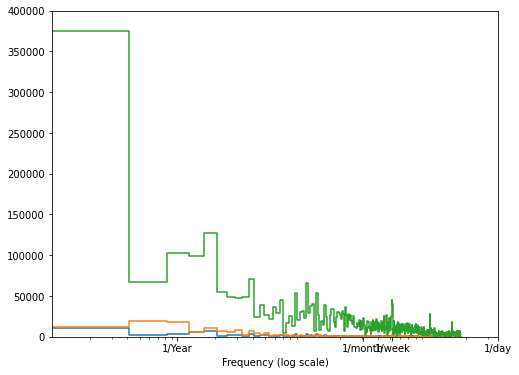

In [290]:
for target in target_columns:
  fft = tf.signal.rfft(df[target])
  f_per_dataset = np.arange(0, len(fft))

  n_samples_h = len(df[target])
  days_per_year = 365.2524
  years_per_dataset = n_samples_h/(days_per_year)

  f_per_year = f_per_dataset/years_per_dataset
  plt.step(f_per_year, np.abs(fft))
  plt.xscale('log')
  plt.ylim(0, 400000)
  plt.xlim([0.1, max(plt.xlim())])
  plt.xticks([1, 365.2524/12, 365.2524/7, 365.2524], labels=['1/Year', '1/month', '1/week', '1/day'])
  _ = plt.xlabel('Frequency (log scale)')

In [291]:
def busday(x, **params):
  '''
  working days from the beggining of month until x (included)
  @x datetime
  acepta como parametro holidays ver https://numpy.org/doc/stable/reference/generated/numpy.busday_count.html
  '''
  first_date_of_month = x.replace(day = 1, hour=0, minute=0, second=0, microsecond=0)
  last_date = x + timedelta(days=1)
  d = np.busday_count(first_date_of_month.strftime('%Y-%m-%d'), last_date.strftime('%Y-%m-%d'), **params) 
  return(d)
  
  
ROLL_WINDOW = 21

# time features
#Add temporal features:
#*   coded values of weekday, day of the month, month of the year, 
#*   temporal periocity
#*   holiday: lamentablemente no sabemos el lugar, por lo que no conocemos los feriados
#
#las variables temporales luego se shiftean al pasado.. para manter el conjunto de datos agrego datos vacios a futuro
new_fromdate = df['DATE'].min() 
new_todate = df['DATE'].max() + timedelta(days=ROLL_WINDOW)
print('Desde ' + str(new_fromdate) + \
      ' hasta ' + str(new_todate) + \
      ' agregando ' + str(ROLL_WINDOW) + ' dias a futuro.')
range_dates = pd.date_range(start=new_fromdate, end=new_todate, freq="D")
temporal_features_df = pd.DataFrame({'DATE':range_dates})
#
# time-coded features
temporal_features_df['year']      = temporal_features_df['DATE'].dt.year      
temporal_features_df['month']     = temporal_features_df['DATE'].dt.month     
temporal_features_df['week']      = temporal_features_df['DATE'].dt.week
temporal_features_df['day']       = temporal_features_df['DATE'].dt.day       
temporal_features_df['weekday']   = temporal_features_df['DATE'].dt.weekday  
temporal_features_df['weekday_name'] = temporal_features_df['weekday'].map({0:'Monday',1:'Tuesday', 2:'Wednesday',3:'Thursday', 4:'Friday', 5:'Saturday',6:'Sunday'})
#
#workday and busday: working days from the beggining of month until x (included)
temporal_features_df['workday'] = (temporal_features_df['DATE'].dt.weekday<5).astype(int) #Monday-Friday
temporal_features_df['busday'] = [busday(x) for x in temporal_features_df['DATE']]
#
#rolling and shifting
#temporal_features_df['rolling_sum_workday_t21']      = temporal_features_df['workday'].transform(lambda x: x.rolling(ROLL_WINDOW).sum())
#temporal_features_df['shift_rolling_sum_workday_t21'] = temporal_features_df['rolling_sum_workday_t21'].shift(periods=-ROLL_WINDOW) #corro hacia atras 21 dias estas variables, porque conozco el futuro de ellas
temporal_features_df['shift_workday_t21'] = temporal_features_df['workday'].shift(periods=-ROLL_WINDOW) #corro hacia atras 21 dias estas variables, porque conozco el futuro de ellas
temporal_features_df['shift_busday_t21'] = temporal_features_df['busday'].shift(periods=-ROLL_WINDOW) #corro hacia atras 21 dias estas variables, porque conozco el futuro de ellas
#
df = df.merge(temporal_features_df, on='DATE', how='left')

display(df)


Desde 2019-06-11 00:00:00 hasta 2021-12-03 00:00:00 agregando 21 dias a futuro.


,DATE,CATEG-1,CATEG-2,CATEG-3,timestamp_s,year_sin,year_cos,year,month,week,day,weekday,weekday_name,workday,busday,shift_workday_t21,shift_busday_t21
0,2019-06-11,27,15,642,1.560211e+09,0.361545,-0.932355,2019,6,24,11,1,Tuesday,1,7,1.0,2.0
1,2019-06-12,26,13,679,1.560298e+09,0.345453,-0.938436,2019,6,24,12,2,Wednesday,1,8,1.0,3.0
2,2019-06-13,24,8,561,1.560384e+09,0.329259,-0.944240,2019,6,24,13,3,Thursday,1,9,1.0,4.0
3,2019-06-14,18,9,520,1.560470e+09,0.312967,-0.949764,2019,6,24,14,4,Friday,1,10,1.0,5.0
4,2019-06-15,15,9,422,1.560557e+09,0.296583,-0.955007,2019,6,24,15,5,Saturday,0,10,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,2021-11-08,63,21,2812,1.636330e+09,-0.796957,0.604036,2021,11,45,8,0,Monday,1,6,1.0,21.0
882,2021-11-09,65,13,2894,1.636416e+09,-0.786449,0.617656,2021,11,45,9,1,Tuesday,1,7,1.0,22.0
883,2021-11-10,189,18,7551,1.636502e+09,-0.775707,0.631093,2021,11,45,10,2,Wednesday,1,8,1.0,1.0
884,2021-11-11,194,20,6294,1.636589e+09,-0.764737,0.644343,2021,11,45,11,3,Thursday,1,9,1.0,2.0


ATENCION: los primeros features de df deben ser los targets para algunos modelos

## Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [292]:
format(df.iloc[int(n*0.7)]['DATE'], '%Y-%m-%d')

'2021-02-20'

Los splits de train|val|test son: 2021-02-20 2021-08-16


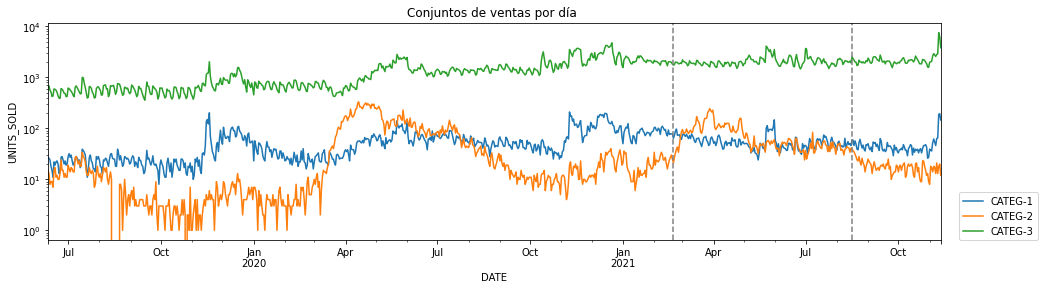

<Figure size 10240x1920 with 0 Axes>

In [293]:
column_indices = {name: i for i, name in enumerate(df[features_columns].columns)}

n = len(df)
num_features = df[features_columns].shape[1]

train_df = df[features_columns][0:int(n*0.7)]
val_df = df[features_columns][int(n*0.7):int(n*0.9)]
test_df = df[features_columns][int(n*0.9):]


SPLIT_DATE_TRAIN = format(df.iloc[int(n*0.7)]['DATE'], '%Y-%m-%d')
SPLIT_DATE_TEST = format(df.iloc[int(n*0.9)]['DATE'], '%Y-%m-%d')
print('Los splits de train|val|test son: ' + SPLIT_DATE_TRAIN + ' ' + SPLIT_DATE_TEST)
#
plot_line(df[['DATE'] + target_columns].set_index('DATE'), 
          "Conjuntos de ventas por día ", xlabel='DATE', ylabel="UNITS_SOLD",
          v=[SPLIT_DATE_TRAIN, SPLIT_DATE_TEST], xlim=(None, None), ylim=(0, None),
          math_scale=False, y_logscale=True, y_integer=False,
          show_legend=True, bbox_to_anchor=(1.02, 0),  bbox_loc="lower left", subplots=False, figsize=(16,4))

## Normalize the data


In [294]:
train_mean = train_df.mean()
train_std = train_df.std()

print(train_mean)
print(train_std)

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

CATEG-1                53.464516
CATEG-2                40.295161
CATEG-3              1247.229032
year_sin               -0.148122
weekday                 2.996774
workday                 0.716129
busday                 11.272581
shift_workday_t21       0.716129
shift_busday_t21       11.183871
dtype: float64
CATEG-1               35.631443
CATEG-2               64.382728
CATEG-3              786.291989
year_sin               0.662953
weekday                1.997573
workday                0.451239
busday                 6.275440
shift_workday_t21      0.451239
shift_busday_t21       6.316509
dtype: float64


In [295]:
df_std

,CATEG-1,CATEG-2,CATEG-3,year_sin,weekday,workday,busday,shift_workday_t21,shift_busday_t21
0,-0.742729,-0.392887,-0.769726,0.768783,-0.999600,0.629092,-0.680842,0.629092,-1.453947
1,-0.770794,-0.423952,-0.722669,0.744510,-0.498993,0.629092,-0.521490,0.629092,-1.295632
2,-0.826925,-0.501612,-0.872741,0.720083,0.001615,0.629092,-0.362139,0.629092,-1.137317
3,-0.995315,-0.486080,-0.924884,0.695509,0.502222,0.629092,-0.202787,0.629092,-0.979001
4,-1.079510,-0.486080,-1.049520,0.670795,1.002830,-1.587028,-0.202787,-1.587028,-0.979001
...,...,...,...,...,...,...,...,...,...
881,0.267614,-0.299695,1.990063,-0.978704,-1.500208,0.629092,-0.840193,0.629092,1.554043
882,0.323745,-0.423952,2.094350,-0.962853,-0.999600,0.629092,-0.680842,0.629092,1.712359
883,3.803817,-0.346291,8.017087,-0.946651,-0.498993,0.629092,-0.521490,0.629092,-1.612263
884,3.944142,-0.315227,6.418444,-0.930102,0.001615,0.629092,-0.362139,0.629092,-1.453947


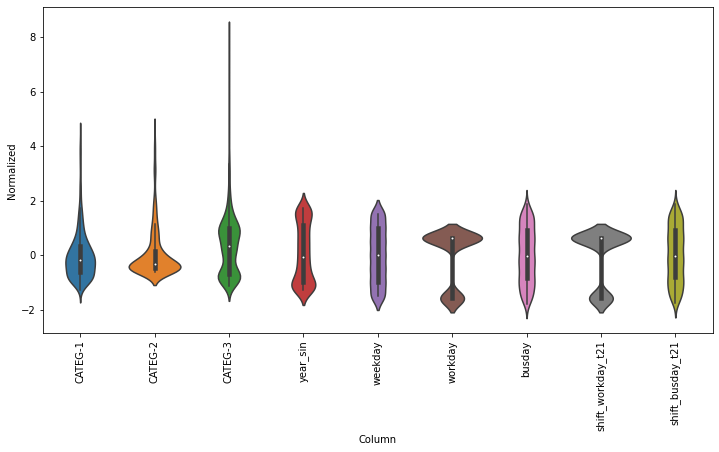

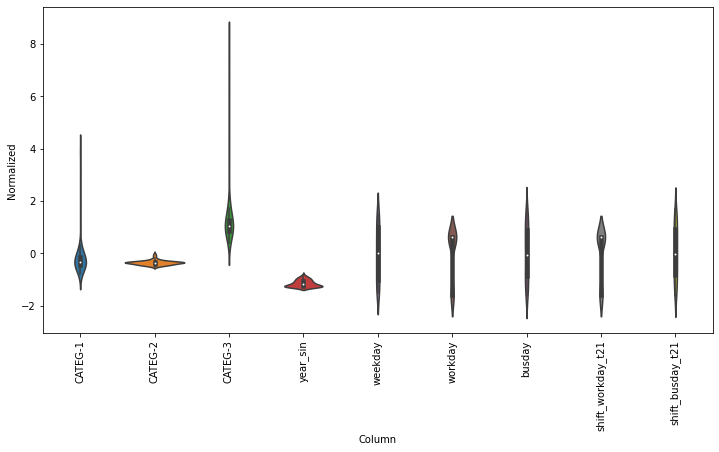

In [296]:
#Now, peek at the distribution of the features. 
df_std = (df[features_columns] - train_mean) / train_std
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data= df_std.melt(var_name='Column', value_name='Normalized'))
_ = ax.set_xticklabels(features_columns, rotation=90)

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=test_df.melt(var_name='Column', value_name='Normalized'))
_ = ax.set_xticklabels(features_columns, rotation=90)
plt.show()

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 



The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [297]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='CATEG-1', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()
    plt.xlabel('Time [d]')


  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds


  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

Our target window

In [298]:
w1 = WindowGenerator(input_width=21, label_width=21, shift=21,
                     label_columns=target_columns)
w1

Total window size: 42
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Label indices: [21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Label column name(s): ['CATEG-1', 'CATEG-2', 'CATEG-3']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.


In [299]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 42, 9)
Inputs shape: (3, 21, 9)
Labels shape: (3, 21, 3)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['CATEG-1']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

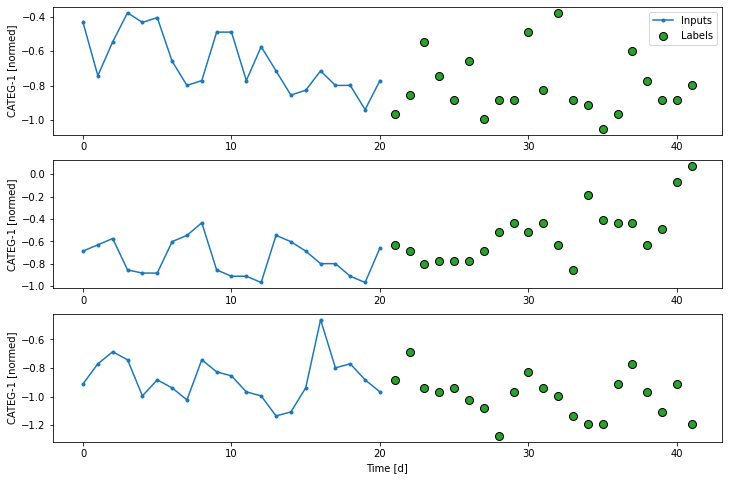

In [300]:
w1.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

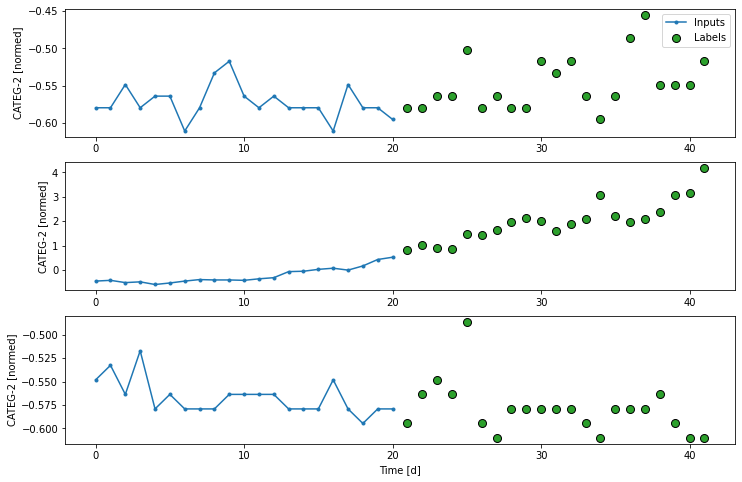

In [301]:
w1.plot(plot_col='CATEG-2')

#w1.plot(plot_col='year_sin')

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [302]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 21, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 21, 3), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [303]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 21, 9)
Labels shape (batch, time, features): (32, 21, 3)


# Multi-step models

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of daily samples. However, here, the models will learn to predict 21 days into the future, given 21 days of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 42
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Label indices: [21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Label column name(s): ['CATEG-1', 'CATEG-2', 'CATEG-3']
(TensorSpec(shape=(None, 21, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 21, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 21, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21, 3), dtype=tf.float32, name=None))


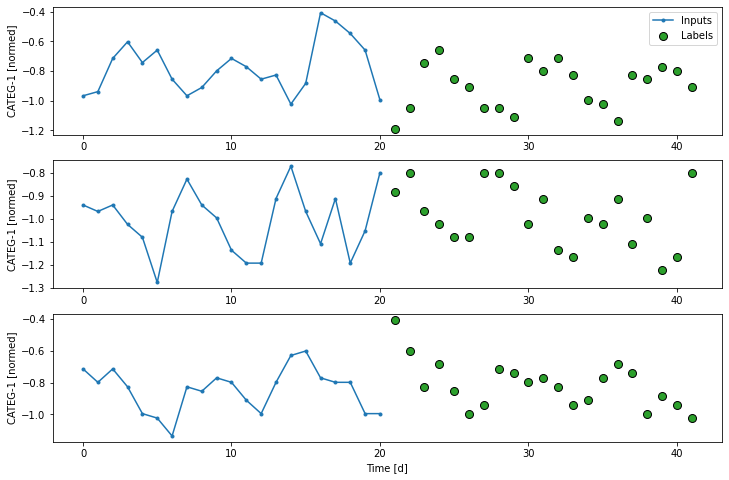

In [304]:
IN_STEPS = 21
OUT_STEPS = 21
multi_window = WindowGenerator(input_width=IN_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS,
                               label_columns=target_columns
                               )

multi_window.plot()
print(multi_window)
print(multi_window.train.element_spec)
print(multi_window.val.element_spec)
print(multi_window.test.element_spec)

General training procedure:

In [347]:
def compile_and_fit(model, window, learning_rate = 0.01, patience=2, max_epochs = 20):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

We will store performance metrics of each model in these variables:

In [306]:
multi_val_performance = {}
multi_performance = {}

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

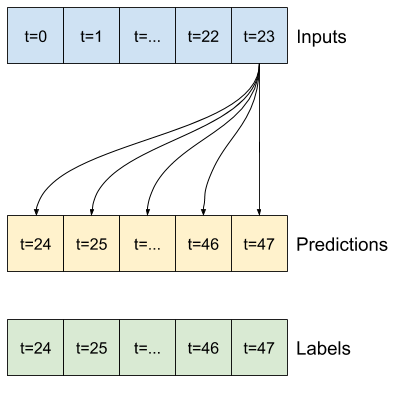

5/5 [==============================] - 0s 4ms/step - loss: 0.4962 - mean_absolute_error: 0.4709


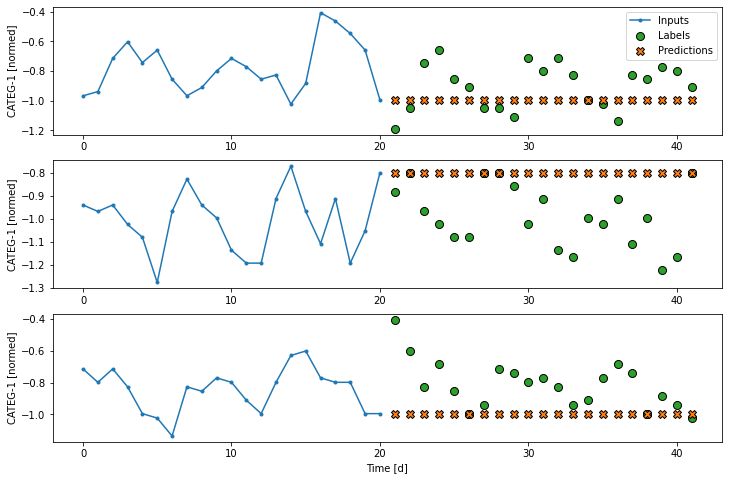

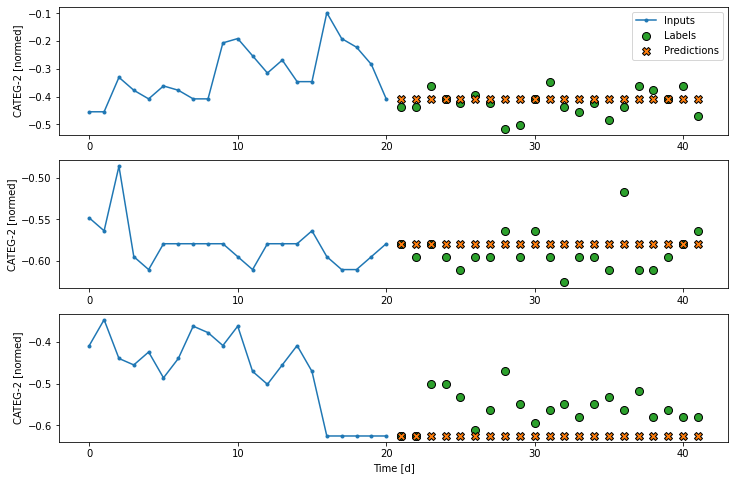

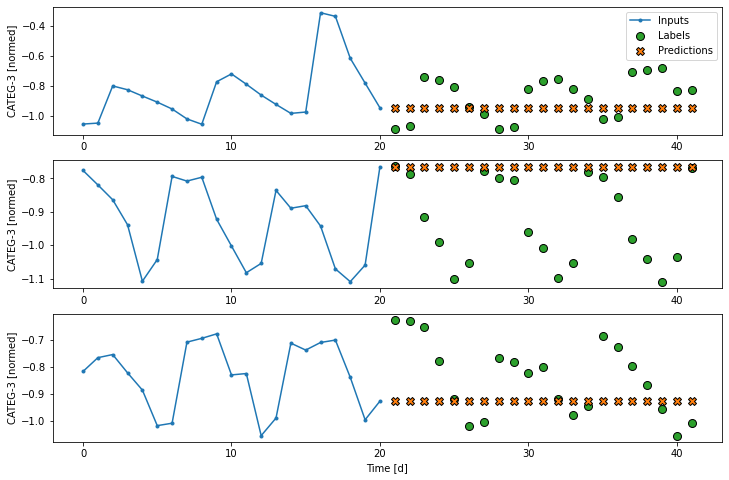

In [307]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :NUM_TARGETS], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline, plot_col='CATEG-1')
multi_window.plot(last_baseline, plot_col='CATEG-2')
multi_window.plot(last_baseline, plot_col='CATEG-3')

Since this task is to predict 21 days into the future, given 21 days of the past, another simple approach is to repeat the previous 21 days, assuming tomorrow will be similar:

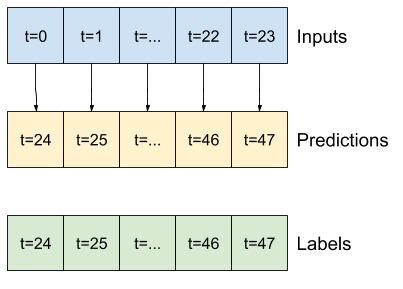

5/5 [==============================] - 0s 4ms/step - loss: 0.5479 - mean_absolute_error: 0.4782


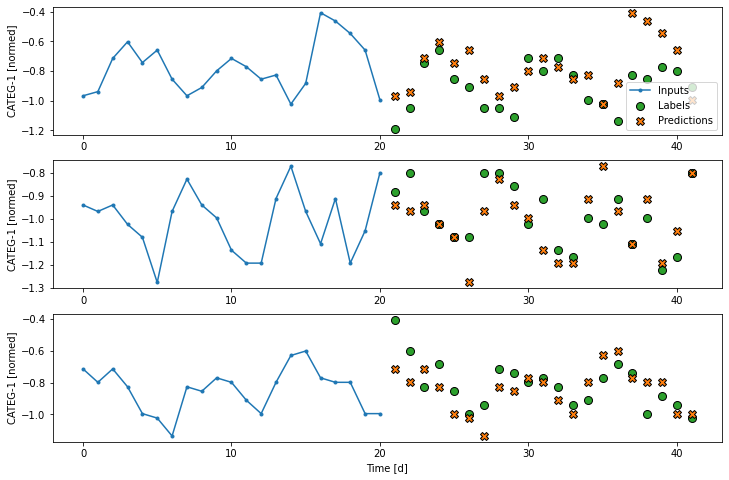

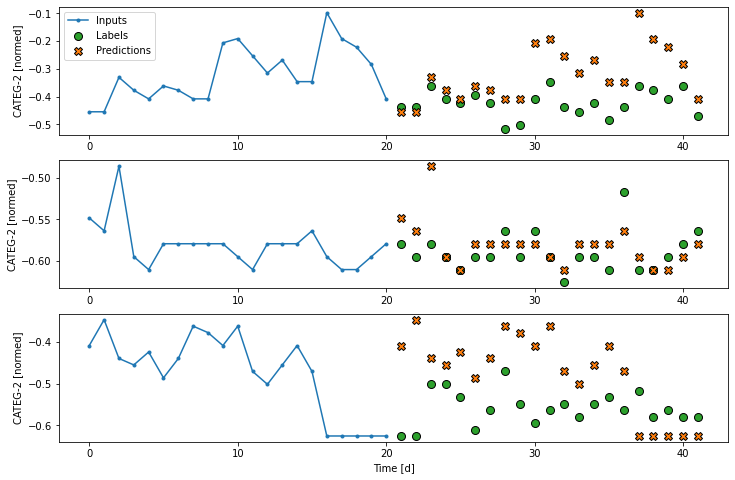

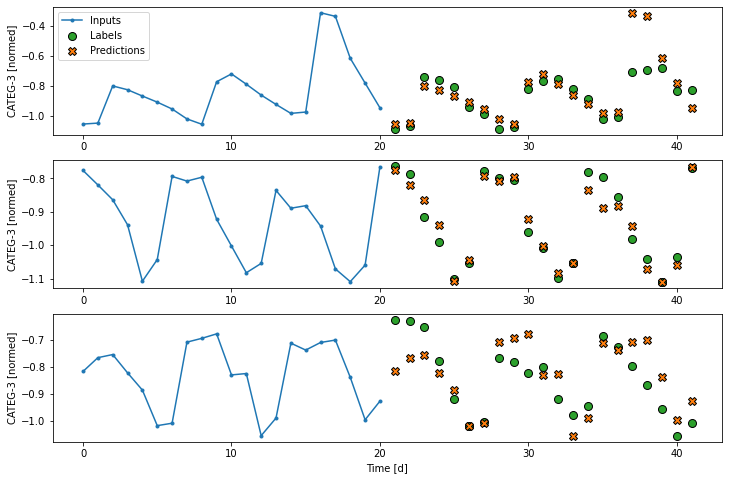

In [308]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs[:, -OUT_STEPS:, :NUM_TARGETS]

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline, plot_col='CATEG-1')
multi_window.plot(repeat_baseline, plot_col='CATEG-2')
multi_window.plot(repeat_baseline, plot_col='CATEG-3')

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

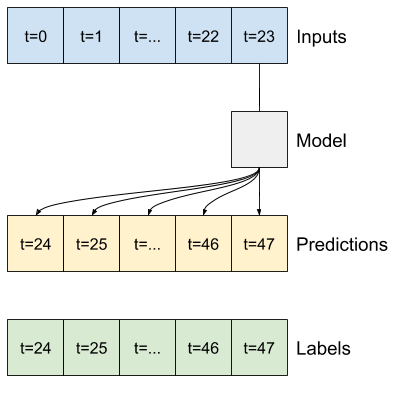

Epoch 1/20
19/19 [==============================] - 1s 18ms/step - loss: 1.0007 - mean_absolute_error: 0.7354 - val_loss: 0.8012 - val_mean_absolute_error: 0.6324
Epoch 2/20
19/19 [==============================] - 0s 9ms/step - loss: 0.9471 - mean_absolute_error: 0.7115 - val_loss: 0.7758 - val_mean_absolute_error: 0.6233
Epoch 3/20
19/19 [==============================] - 0s 9ms/step - loss: 0.9020 - mean_absolute_error: 0.6910 - val_loss: 0.7540 - val_mean_absolute_error: 0.6157
Epoch 4/20
19/19 [==============================] - 0s 9ms/step - loss: 0.8601 - mean_absolute_error: 0.6710 - val_loss: 0.7369 - val_mean_absolute_error: 0.6096
Epoch 5/20
19/19 [==============================] - 0s 8ms/step - loss: 0.8219 - mean_absolute_error: 0.6521 - val_loss: 0.7205 - val_mean_absolute_error: 0.6038
Epoch 6/20
19/19 [==============================] - 0s 7ms/step - loss: 0.7870 - mean_absolute_error: 0.6344 - val_loss: 0.7065 - val_mean_absolute_error: 0.5989
Epoch 7/20
19/19 [=========

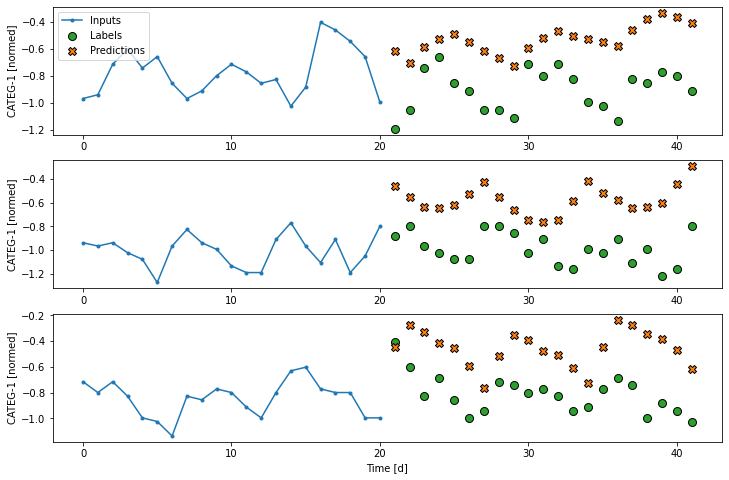

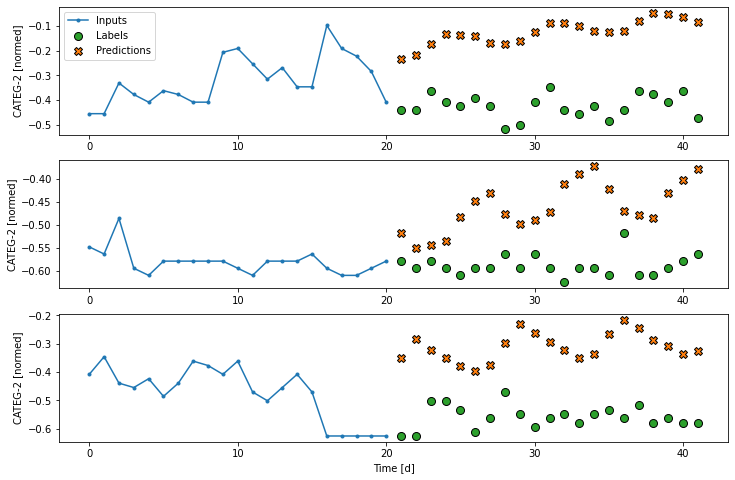

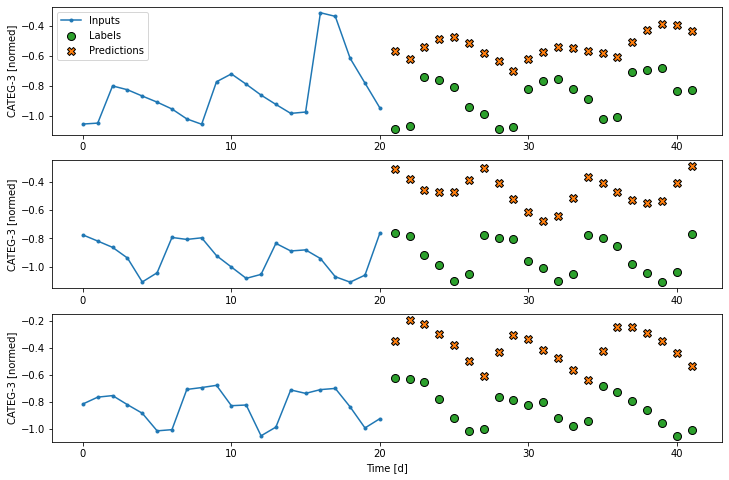

In [309]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*NUM_TARGETS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, NUM_TARGETS])
])

history = compile_and_fit(multi_linear_model, multi_window)

#IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model, plot_col='CATEG-1')
multi_window.plot(multi_linear_model, plot_col='CATEG-2')
multi_window.plot(multi_linear_model, plot_col='CATEG-3')

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

Epoch 1/30
19/19 [==============================] - 1s 20ms/step - loss: 0.8854 - mean_absolute_error: 0.6810 - val_loss: 0.6501 - val_mean_absolute_error: 0.5728
Epoch 2/30
19/19 [==============================] - 0s 9ms/step - loss: 0.5569 - mean_absolute_error: 0.5044 - val_loss: 0.5511 - val_mean_absolute_error: 0.5456
Epoch 3/30
19/19 [==============================] - 0s 10ms/step - loss: 0.3970 - mean_absolute_error: 0.3922 - val_loss: 0.5878 - val_mean_absolute_error: 0.5866
Epoch 4/30
19/19 [==============================] - 0s 7ms/step - loss: 0.3562 - mean_absolute_error: 0.3746 - val_loss: 0.5511 - val_mean_absolute_error: 0.5616
Epoch 5/30
19/19 [==============================] - 0s 10ms/step - loss: 0.3358 - mean_absolute_error: 0.3562 - val_loss: 0.5232 - val_mean_absolute_error: 0.5416
Epoch 6/30
19/19 [==============================] - 0s 10ms/step - loss: 0.3208 - mean_absolute_error: 0.3441 - val_loss: 0.5117 - val_mean_absolute_error: 0.5322
Epoch 7/30
19/19 [======

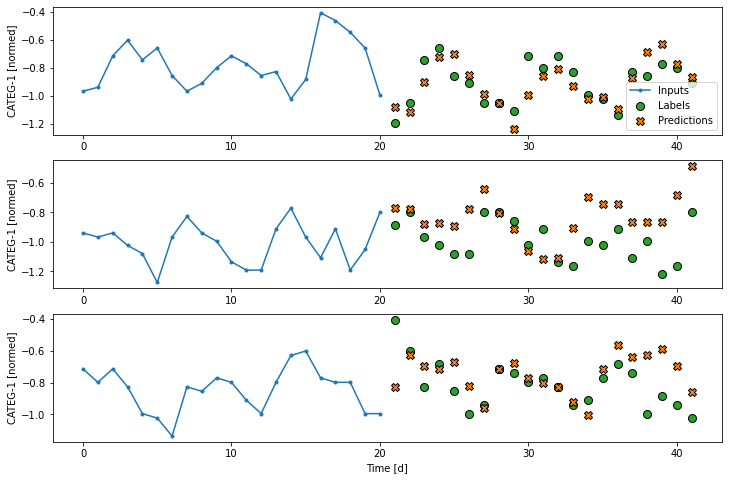

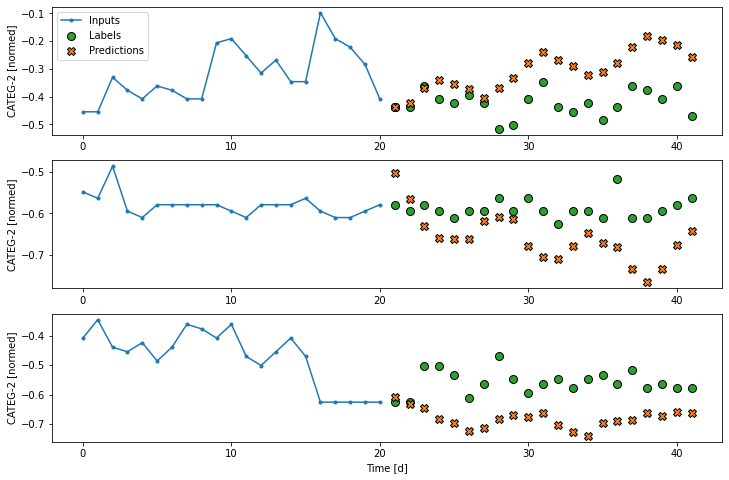

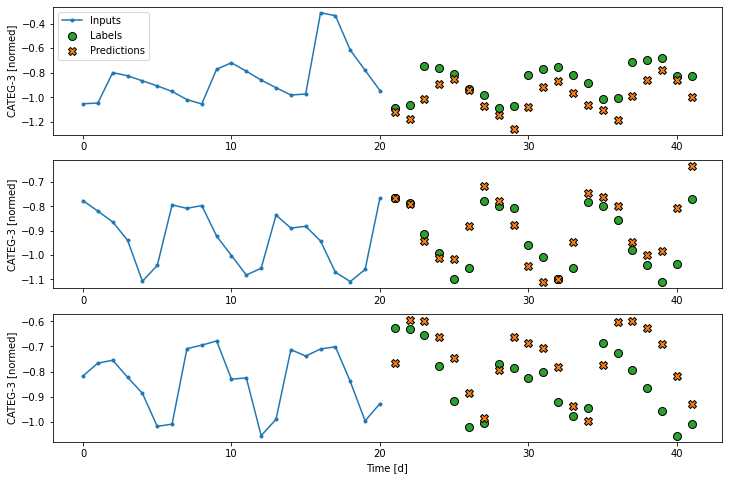

In [310]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(300, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*NUM_TARGETS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, NUM_TARGETS])
])

history = compile_and_fit(multi_dense_model, multi_window, max_epochs = 30)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model, plot_col='CATEG-1')
multi_window.plot(multi_dense_model, plot_col='CATEG-2')
multi_window.plot(multi_dense_model, plot_col='CATEG-3')


#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

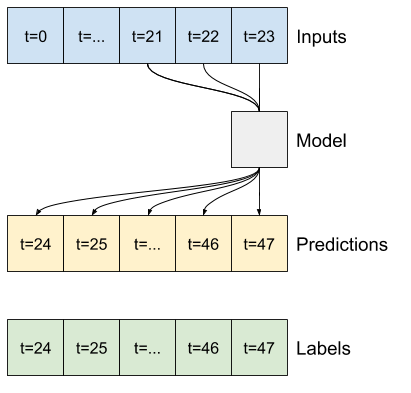

Epoch 1/50
19/19 [==============================] - 3s 58ms/step - loss: 0.8653 - mean_absolute_error: 0.6679 - val_loss: 0.6101 - val_mean_absolute_error: 0.5588
Epoch 2/50
19/19 [==============================] - 1s 24ms/step - loss: 0.4772 - mean_absolute_error: 0.4480 - val_loss: 0.6005 - val_mean_absolute_error: 0.5982
Epoch 3/50
19/19 [==============================] - 1s 22ms/step - loss: 0.3682 - mean_absolute_error: 0.3783 - val_loss: 0.6163 - val_mean_absolute_error: 0.6096
Epoch 4/50
19/19 [==============================] - 1s 31ms/step - loss: 0.3310 - mean_absolute_error: 0.3580 - val_loss: 0.5653 - val_mean_absolute_error: 0.5753
Epoch 5/50
19/19 [==============================] - 1s 35ms/step - loss: 0.3118 - mean_absolute_error: 0.3380 - val_loss: 0.5558 - val_mean_absolute_error: 0.5683
Epoch 6/50
19/19 [==============================] - 1s 28ms/step - loss: 0.2935 - mean_absolute_error: 0.3296 - val_loss: 0.5337 - val_mean_absolute_error: 0.5538
Epoch 7/50
19/19 [====

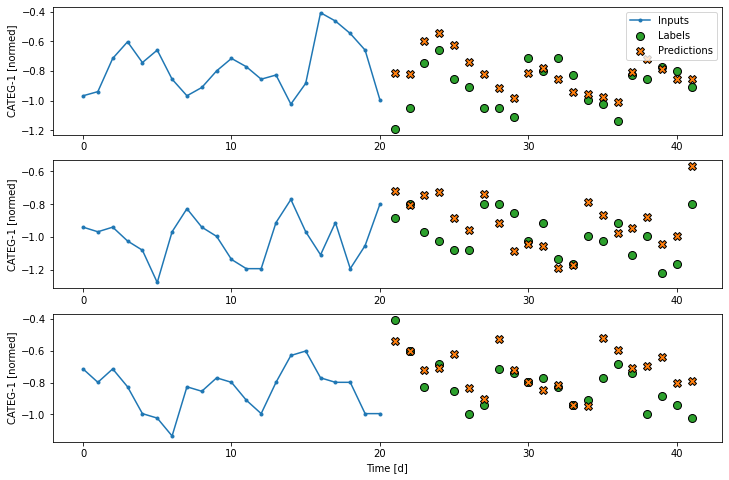

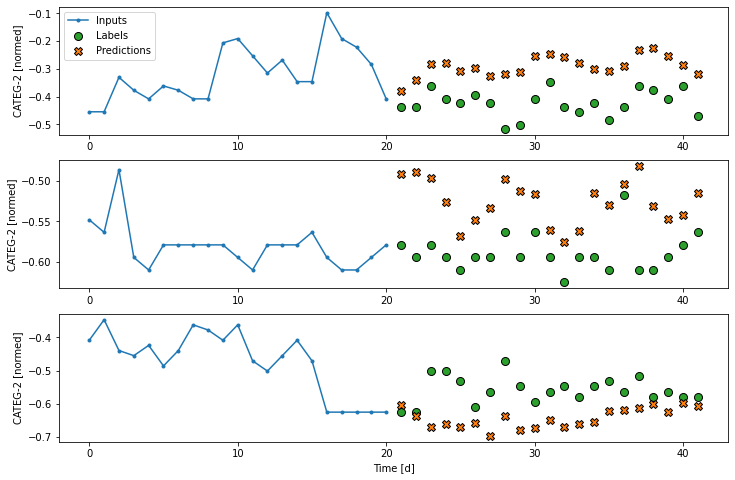

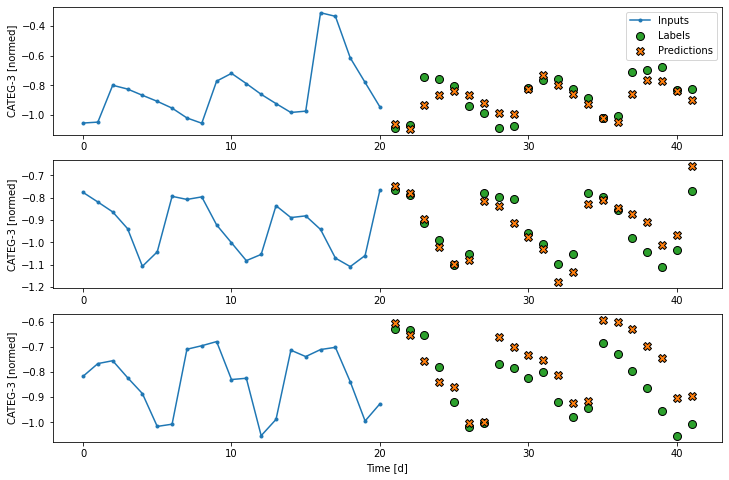

In [354]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(500, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(OUT_STEPS*NUM_TARGETS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, NUM_TARGETS])
])

history = compile_and_fit(multi_conv_model, multi_window, learning_rate=0.0007, patience = 10, max_epochs=50)

#IPython.display.clear_output()
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model, plot_col='CATEG-1')
multi_window.plot(multi_conv_model, plot_col='CATEG-2')
multi_window.plot(multi_conv_model, plot_col='CATEG-3')


#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 21 days, before making a single prediction for the next 21 days.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

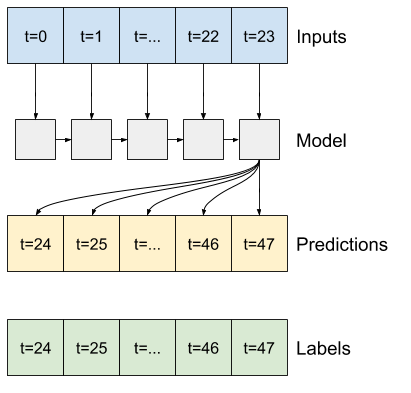


Epoch 1/30
19/19 [==============================] - 4s 76ms/step - loss: 1.0068 - mean_absolute_error: 0.7365 - val_loss: 0.8086 - val_mean_absolute_error: 0.6357
Epoch 2/30
19/19 [==============================] - 0s 16ms/step - loss: 0.9442 - mean_absolute_error: 0.7050 - val_loss: 0.7531 - val_mean_absolute_error: 0.6143
Epoch 3/30
19/19 [==============================] - 0s 17ms/step - loss: 0.8519 - mean_absolute_error: 0.6523 - val_loss: 0.6701 - val_mean_absolute_error: 0.5857
Epoch 4/30
19/19 [==============================] - 0s 19ms/step - loss: 0.7485 - mean_absolute_error: 0.5869 - val_loss: 0.6040 - val_mean_absolute_error: 0.5666
Epoch 5/30
19/19 [==============================] - 0s 18ms/step - loss: 0.6575 - mean_absolute_error: 0.5266 - val_loss: 0.5659 - val_mean_absolute_error: 0.5588
Epoch 6/30
19/19 [==============================] - 0s 18ms/step - loss: 0.5857 - mean_absolute_error: 0.4837 - val_loss: 0.5580 - val_mean_absolute_error: 0.5644
Epoch 7/30
19/19 [====

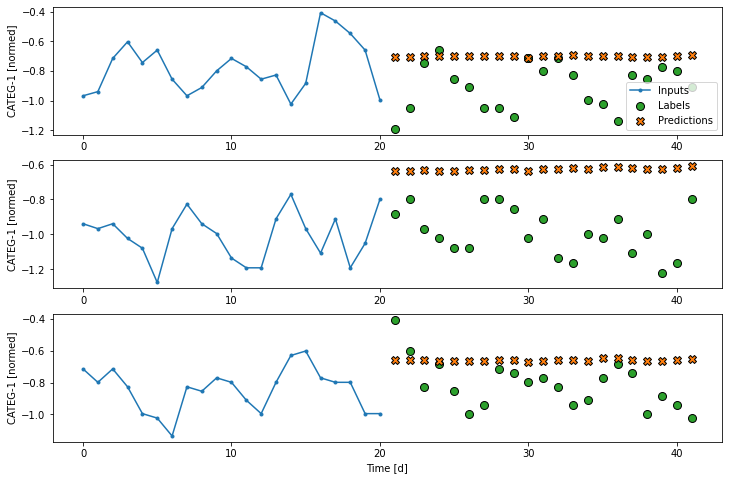

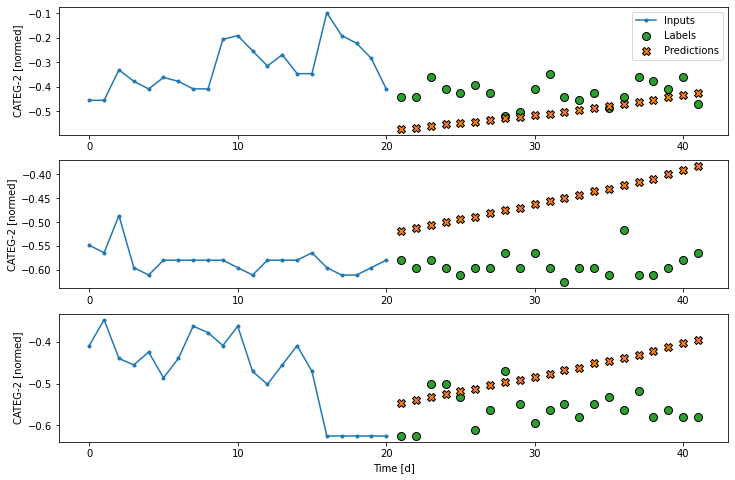

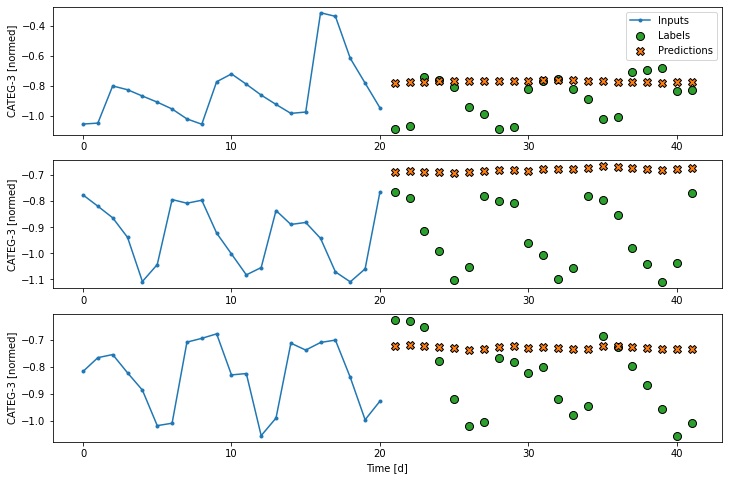

In [312]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(14, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*NUM_TARGETS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, NUM_TARGETS])
])

history = compile_and_fit(multi_lstm_model, multi_window, patience=4, max_epochs = 30)

#IPython.display.clear_output()
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model, plot_col='CATEG-1')
multi_window.plot(multi_lstm_model, plot_col='CATEG-2')
multi_window.plot(multi_lstm_model, plot_col='CATEG-3')

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

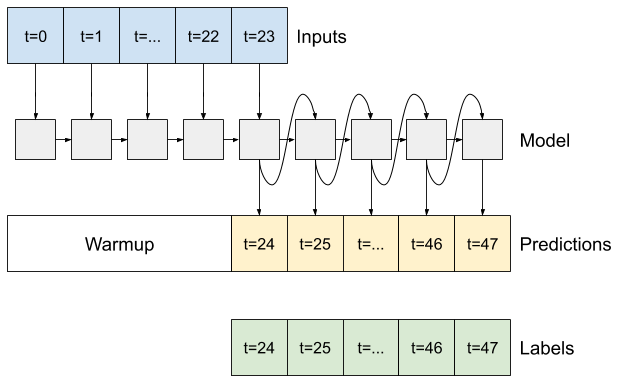

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [313]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [314]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [315]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 9])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [316]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions[:, -OUT_STEPS:, :NUM_TARGETS]

FeedBack.call = call

Test run this model on the example inputs:

In [317]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 21, 3)


Now, train the model:

Epoch 1/20
19/19 [==============================] - 8s 73ms/step - loss: 0.8628 - mean_absolute_error: 0.6674 - val_loss: 0.8251 - val_mean_absolute_error: 0.6815
Epoch 2/20
19/19 [==============================] - 0s 23ms/step - loss: 0.6339 - mean_absolute_error: 0.5568 - val_loss: 0.6600 - val_mean_absolute_error: 0.6171
Epoch 3/20
19/19 [==============================] - 0s 22ms/step - loss: 0.4345 - mean_absolute_error: 0.4270 - val_loss: 0.7646 - val_mean_absolute_error: 0.6891
Epoch 4/20
5/5 [==============================] - 0s 6ms/step - loss: 0.7737 - mean_absolute_error: 0.7033


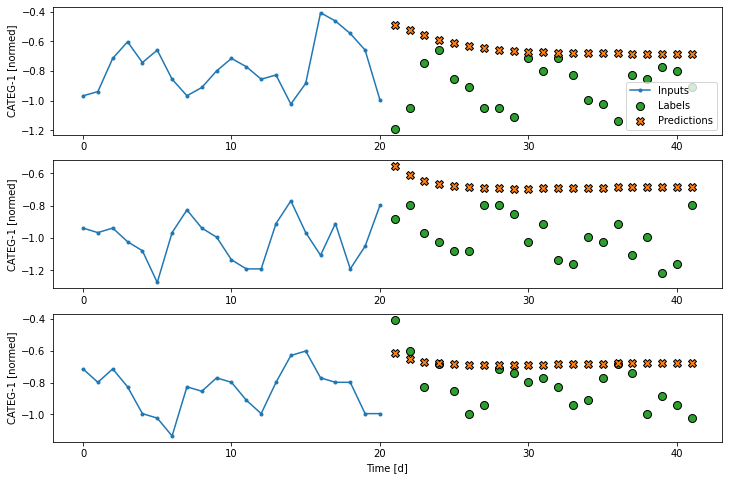

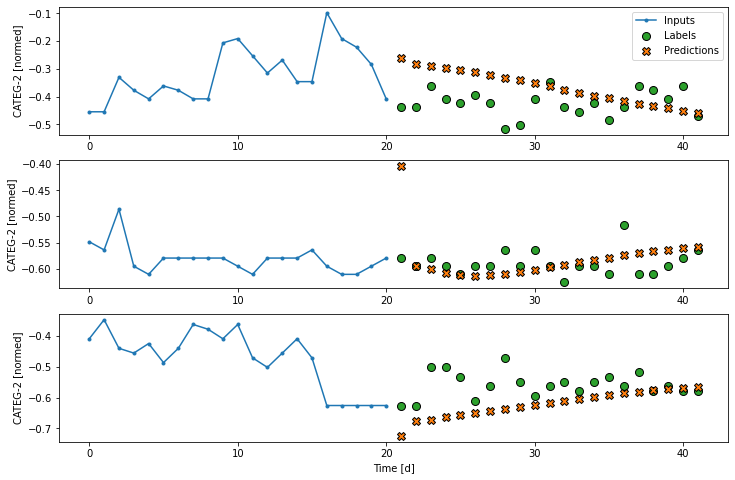

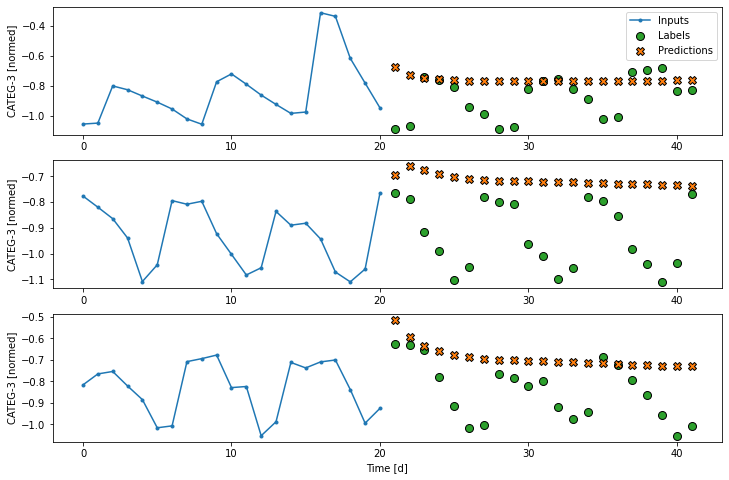

In [318]:
history = compile_and_fit(feedback_model, multi_window)

#IPython.display.clear_output()
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model, plot_col='CATEG-1')
multi_window.plot(feedback_model, plot_col='CATEG-2')
multi_window.plot(feedback_model, plot_col='CATEG-3')

### Performance

There are clearly diminishing returns as a function of model complexity on this problem:

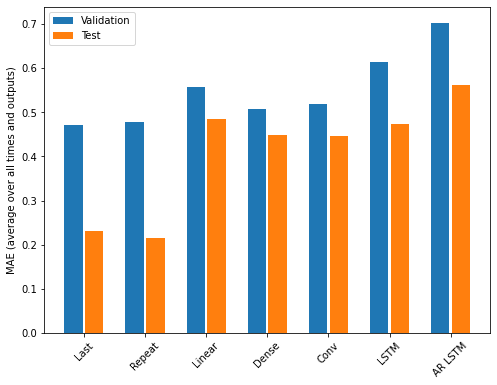

In [319]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_linear_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps. 

In [357]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.2307
Repeat  : 0.2162
Linear  : 0.4844
Dense   : 0.4482
Conv    : 0.4297
LSTM    : 0.4726
AR LSTM : 0.5608


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

In [355]:
best_model = multi_conv_model

27/27 [==============================] - 0s 4ms/step


,DATE,CATEG-1,CATEG-2,CATEG-3,timestamp_s,year_sin,year_cos,year,month,week,day,weekday,weekday_name,workday,busday,shift_workday_t21,shift_busday_t21,CATEG-1_pred,CATEG-2_pred,CATEG-3_pred
0,2019-06-11,27,15,642,1.560211e+09,0.361545,-0.932355,2019,6,24,11,1,Tuesday,1,7,1.0,2.0,NaN,NaN,NaN
1,2019-06-12,26,13,679,1.560298e+09,0.345453,-0.938436,2019,6,24,12,2,Wednesday,1,8,1.0,3.0,NaN,NaN,NaN
2,2019-06-13,24,8,561,1.560384e+09,0.329259,-0.944240,2019,6,24,13,3,Thursday,1,9,1.0,4.0,NaN,NaN,NaN
3,2019-06-14,18,9,520,1.560470e+09,0.312967,-0.949764,2019,6,24,14,4,Friday,1,10,1.0,5.0,NaN,NaN,NaN
4,2019-06-15,15,9,422,1.560557e+09,0.296583,-0.955007,2019,6,24,15,5,Saturday,0,10,0.0,5.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,2021-11-08,63,21,2812,1.636330e+09,-0.796957,0.604036,2021,11,45,8,0,Monday,1,6,1.0,21.0,NaN,NaN,NaN
882,2021-11-09,65,13,2894,1.636416e+09,-0.786449,0.617656,2021,11,45,9,1,Tuesday,1,7,1.0,22.0,NaN,NaN,NaN
883,2021-11-10,189,18,7551,1.636502e+09,-0.775707,0.631093,2021,11,45,10,2,Wednesday,1,8,1.0,1.0,NaN,NaN,NaN
884,2021-11-11,194,20,6294,1.636589e+09,-0.764737,0.644343,2021,11,45,11,3,Thursday,1,9,1.0,2.0,NaN,NaN,NaN


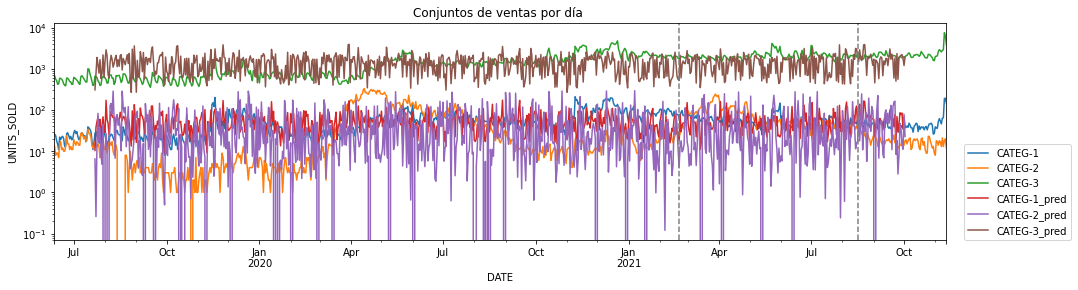

<Figure size 10240x1920 with 0 Axes>

In [356]:
PREDICTION_STEP = 0

df_std = (df[features_columns] - train_mean) / train_std
df_std_tf = multi_window.make_dataset(df_std)

#final prediction
preds_tf = best_model.predict(df_std_tf)
pred_std_df = pd.DataFrame(preds_tf[:,PREDICTION_STEP,:], columns=target_columns)
pred_df = pred_std_df * train_std[target_columns] + train_mean[target_columns]
pred_df['DATE'] = df.iloc[ (len(df) - len(pred_df)+PREDICTION_STEP):]['DATE']
pred_df.rename(columns={t: t+'_pred' for t in target_columns}, inplace=True)

eval_df = df.merge(pred_df, on='DATE', how = 'left')
display(eval_df)

plot_line(eval_df[['DATE'] + target_columns + [t+'_pred' for t in target_columns]].set_index('DATE'), 
          "Conjuntos de ventas por día ", xlabel='DATE', ylabel="UNITS_SOLD",
          v=[SPLIT_DATE_TRAIN, SPLIT_DATE_TEST], xlim=(None, None), ylim=(0, None),
          math_scale=False, y_logscale=True, y_integer=False,
          show_legend=True, bbox_to_anchor=(1.02, 0),  bbox_loc="lower left", subplots=False, figsize=(16,4))